In [1]:
!pip install transformers

In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.model_selection import train_test_split
from scipy.special import softmax
from transformers import BertTokenizer
from transformers import TFBertForSequenceClassification

In [3]:
df = pd.read_csv('cleaned_dataset_tokens.csv')
# df = pd.read_csv('cleaned_dataset.csv')
df.head()

,post,label
0,simply copy and paste the following text into ...,0
1,in order to help increase the booklets downloa...,0
2,as of march <number>th <number> the booklet ha...,0
3,click below for a free download of a colorfull...,1
4,click on the download <number> <number> mb gre...,0


In [4]:
df.shape

(45600, 2)

In [5]:
df.dropna(inplace=True)

In [6]:
df.shape

(45600, 2)

In [7]:
# df.label = df.label.astype(int)

In [8]:
df.head()

,post,label
0,simply copy and paste the following text into ...,0
1,in order to help increase the booklets downloa...,0
2,as of march <number>th <number> the booklet ha...,0
3,click below for a free download of a colorfull...,1
4,click on the download <number> <number> mb gre...,0


In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# tokenizer = BertTokenizer.from_pretrained('vinai/bertweet-base')

In [10]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')
# model = TFBertForSequenceClassification.from_pretrained('vinai/bertweet-base')
# model = TFBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing TFBertForSequenceClassification: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['dropout_37', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# from transformers import AutoTokenizer, AutoModelForSequenceClassification
# tokenizer = AutoTokenizer.from_pretrained("Hate-speech-CNERG/dehatebert-mono-english")
# model = AutoModelForSequenceClassification.from_pretrained("Hate-speech-CNERG/dehatebert-mono-english")

In [12]:
# can be up to 512 for BERT
max_length = 50 

In [13]:
cyber_df_train, cyber_df_test = train_test_split(df, test_size=0.2)

In [14]:
def cyber_gen(df):
    def g():
        for row in df.itertuples():
            text = row.post
            # max length of the text that can go to BERT, add [PAD] tokens, add [CLS], [SEP], add attention mask to not focus on pad tokens
            tokenized = tokenizer(text, max_length=max_length, padding='max_length', truncation=True )
            yield {k: np.array(tokenized[k]) for k in tokenized}, row.label
    return g

input_names = ['input_ids', 'token_type_ids', 'attention_mask']
data_types = ({k: tf.int32 for k in input_names}, tf.int64)
data_shapes = ({k: tf.TensorShape([None]) for k in input_names}, tf.TensorShape([]))

cyber_data_train = tf.data.Dataset.from_generator(cyber_gen(cyber_df_train),data_types, data_shapes).shuffle(100).batch(32).repeat(4)

cyber_data_test = tf.data.Dataset.from_generator(cyber_gen(cyber_df_test),data_types, data_shapes).shuffle(100).batch(32).repeat(4)

In [15]:
cyber_data_train

<RepeatDataset shapes: ({input_ids: (None, None), token_type_ids: (None, None), attention_mask: (None, None)}, (None,)), types: ({input_ids: tf.int32, token_type_ids: tf.int32, attention_mask: tf.int32}, tf.int64)>

In [16]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

es=EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min',restore_best_weights=True)
callbacks_list = [es, checkpoint]

opt=keras.optimizers.Adam(lr=0.00003)
model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics='accuracy')

In [25]:
# from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# def compute_metrics(pred):
#     labels = pred.label_ids
#     preds = pred.predictions.argmax(-1)
#     precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
#     acc = accuracy_score(labels, preds)
#     return {
#         'accuracy': acc,
#         'f1': f1,
#         'precision': precision,
#         'recall': recall
#     }

In [17]:
history = model.fit(
    cyber_data_train,
    epochs=100, 
    steps_per_epoch=64, 
    validation_steps=16,
    validation_data=cyber_data_test, callbacks=[callbacks_list]
)

Epoch 1/100
64/64 [==============================] - ETA: 0s - loss: 0.4316 - accuracy: 0.8149
Epoch 00001: val_accuracy improved from -inf to 0.89258, saving model to model.h5
64/64 [==============================] - 50s 783ms/step - loss: 0.4316 - accuracy: 0.8149 - val_loss: 0.2630 - val_accuracy: 0.8926
Epoch 2/100
64/64 [==============================] - ETA: 0s - loss: 0.2638 - accuracy: 0.8901
Epoch 00002: val_accuracy improved from 0.89258 to 0.91211, saving model to model.h5
64/64 [==============================] - 47s 727ms/step - loss: 0.2638 - accuracy: 0.8901 - val_loss: 0.2057 - val_accuracy: 0.9121
Epoch 3/100
64/64 [==============================] - ETA: 0s - loss: 0.2405 - accuracy: 0.8970
Epoch 00003: val_accuracy improved from 0.91211 to 0.92383, saving model to model.h5
64/64 [==============================] - 47s 731ms/step - loss: 0.2405 - accuracy: 0.8970 - val_loss: 0.2146 - val_accuracy: 0.9238
Epoch 4/100
64/64 [==============================] - ETA: 0s - loss

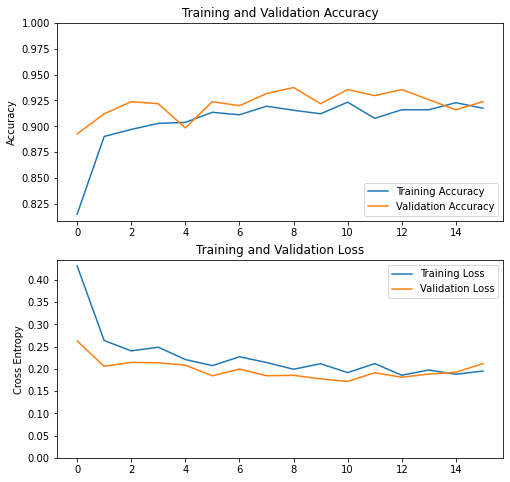

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [19]:
model.num_parameters()

109483778

In [20]:
model.load_weights('model.h5')

In [21]:
results = model.evaluate(cyber_data_test)     
print(f'model_loss = {results[0]}')
print(f'model_accuracy = {results[1]}')

1140/1140 [==============================] - 264s 232ms/step - loss: 0.2073 - accuracy: 0.9192
model_loss = 0.20732490718364716
model_accuracy = 0.9191886186599731


In [22]:
# SAVED_MODEL_DIR = './bert_pretrained_model/'
# model.save_pretrained(SAVED_MODEL_DIR)

In [23]:
# model = TFBertForSequenceClassification.from_pretrained('./bert_pretrained_model/')

In [24]:
new_tweet = "This is our final project in ITC"
tokenized = tokenizer(new_tweet)
logits = model.predict({k: np.array(tokenized[k])[None] for k in input_names})[0]
scores = softmax(logits, axis=1)[:,1]
print(1-scores[0], 'probability that input text is non-cyberbulling')
print(scores[0], 'probability that input text is cyberbulling')

0.9943813909776509 probability that input text is non-cyberbulling
0.005618609 probability that input text is cyberbulling
